In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [7]:
train_dir = '/Users/idayeong/Desktop/Dataset/Train'

In [8]:
# crop the center square of an image (100,100)
def center_crop(image, label, crop_size=100): 
    height, width, _ = image.shape[1:] 
    crop_size = min(height, width, crop_size)
    center_x = width // 2
    center_y = height // 2
    cropped_image = image[:, center_y - crop_size // 2:center_y + crop_size // 2,
                     center_x - crop_size // 2:center_x + crop_size // 2, :]

    return cropped_image, label

# set image size
IMG_SIZE = (100, 100)  # size reducing 256 to 100

# image train dataset ; one-hot coding, batch size, image size
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 image_size=IMG_SIZE,
                                                                 color_mode='grayscale')

# apply the crop function
train_data = train_data.map(lambda x, y: center_crop(x, y, crop_size=100))

# split dataset for Train and Test
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_dataset = train_data.take(train_size)
test_dataset = train_data.skip(train_size)

# from Train dataset split dataset for Validation
validation_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - validation_size
train_dataset = train_dataset.take(train_size)
validation_dataset = train_dataset.skip(train_size - validation_size)

# print to determine the Size of Divided Datasets
print("Train data count:", len(train_dataset))
print("Validation data count:", len(validation_dataset))
print("Test data count:", len(test_dataset))

Found 140002 files belonging to 2 classes.
Train data count: 3150
Validation data count: 350
Test data count: 876


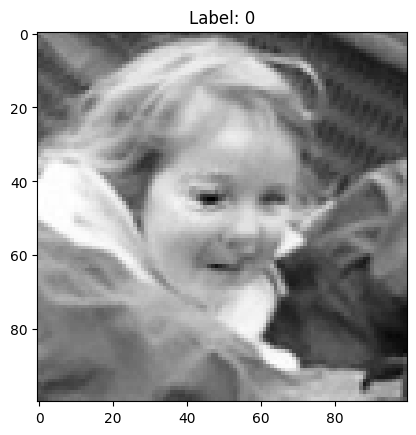

In [9]:
# get a random image from the training dataset
for images, labels in train_data.take(1):
    # randomly select an image from among the batch
    random_index = np.random.randint(0, images.shape[0])
    random_image, random_label = images[random_index], labels[random_index]

    # transforming an image into (height, width) form
    random_image = np.squeeze(random_image.numpy(), axis=-1)

    # visualize random images
    plt.imshow(random_image, cmap='gray')  
    plt.title(f"Label: {np.argmax(random_label)}")
    plt.show()


In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Define model
model = models.Sequential()

# Convolutional Layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(layers.Conv2D(64, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten Layer
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(layers.Dense(2, activation='softmax')) 


optimizer = Adam(learning_rate=0.0001)

# Deliver the optimizer set in the optimizer parameter when compiling the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                       tf.keras.metrics.F1Score(average=None, name='f1_score'),
                       tf.keras.metrics.LogCoshError()])

model.summary()

try:
    # Train the model
    model.fit(train_dataset, epochs=5, validation_data=validation_dataset)
except Exception as e:
    print("An error occurred during training:")
    print(str(e))


# Model evaluation
test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_logloss = model.evaluate(test_dataset)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1-Score: {test_f1_score}')
print(f'Test Logarithmic Loss: {test_logloss}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 33856)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

1/1 [==============================] - 0s 101ms/step


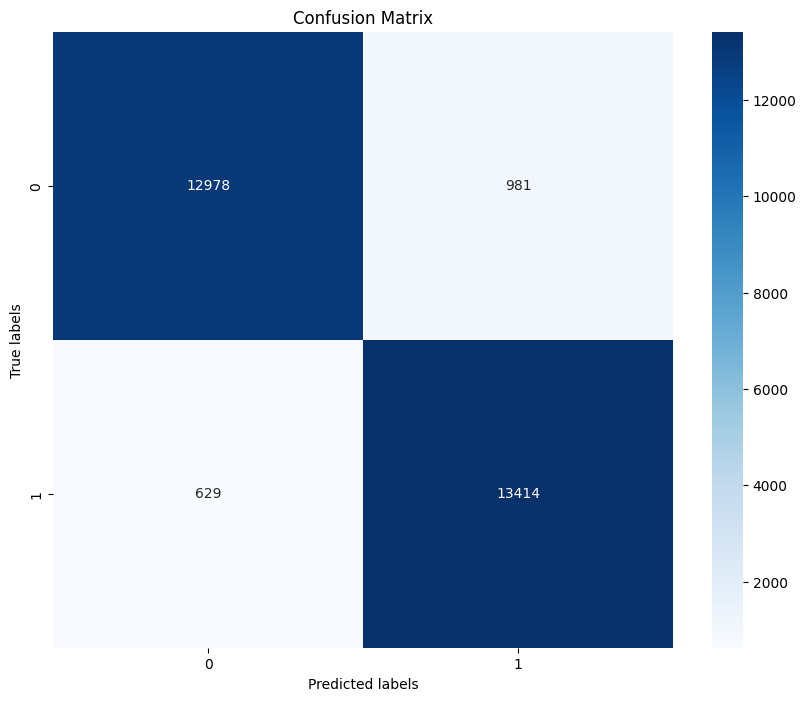

In [11]:
import seaborn as sns


# 테스트 데이터셋에서 실제 레이블과 예측값 수집
true_labels = []
predicted_labels = []
for images, labels in test_dataset:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    true = np.argmax(labels.numpy(), axis=1)
    
    true_labels.extend(true)
    predicted_labels.extend(preds)

# 혼동 행렬 생성
confusion_mtx = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()